In [1]:
%matplotlib widget
import numpy as np
import seaborn as sns
import pandas as pd
from functools import reduce
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import sys
import os


In [2]:
def load_csv(path):
    return pd.read_csv(path)

0/1: FV10__20190620_111343_univariate_ng2_rstats
/home/dkermany/ripley_results/FV10__20190620_111343_univariate_ng2_rstats.csv


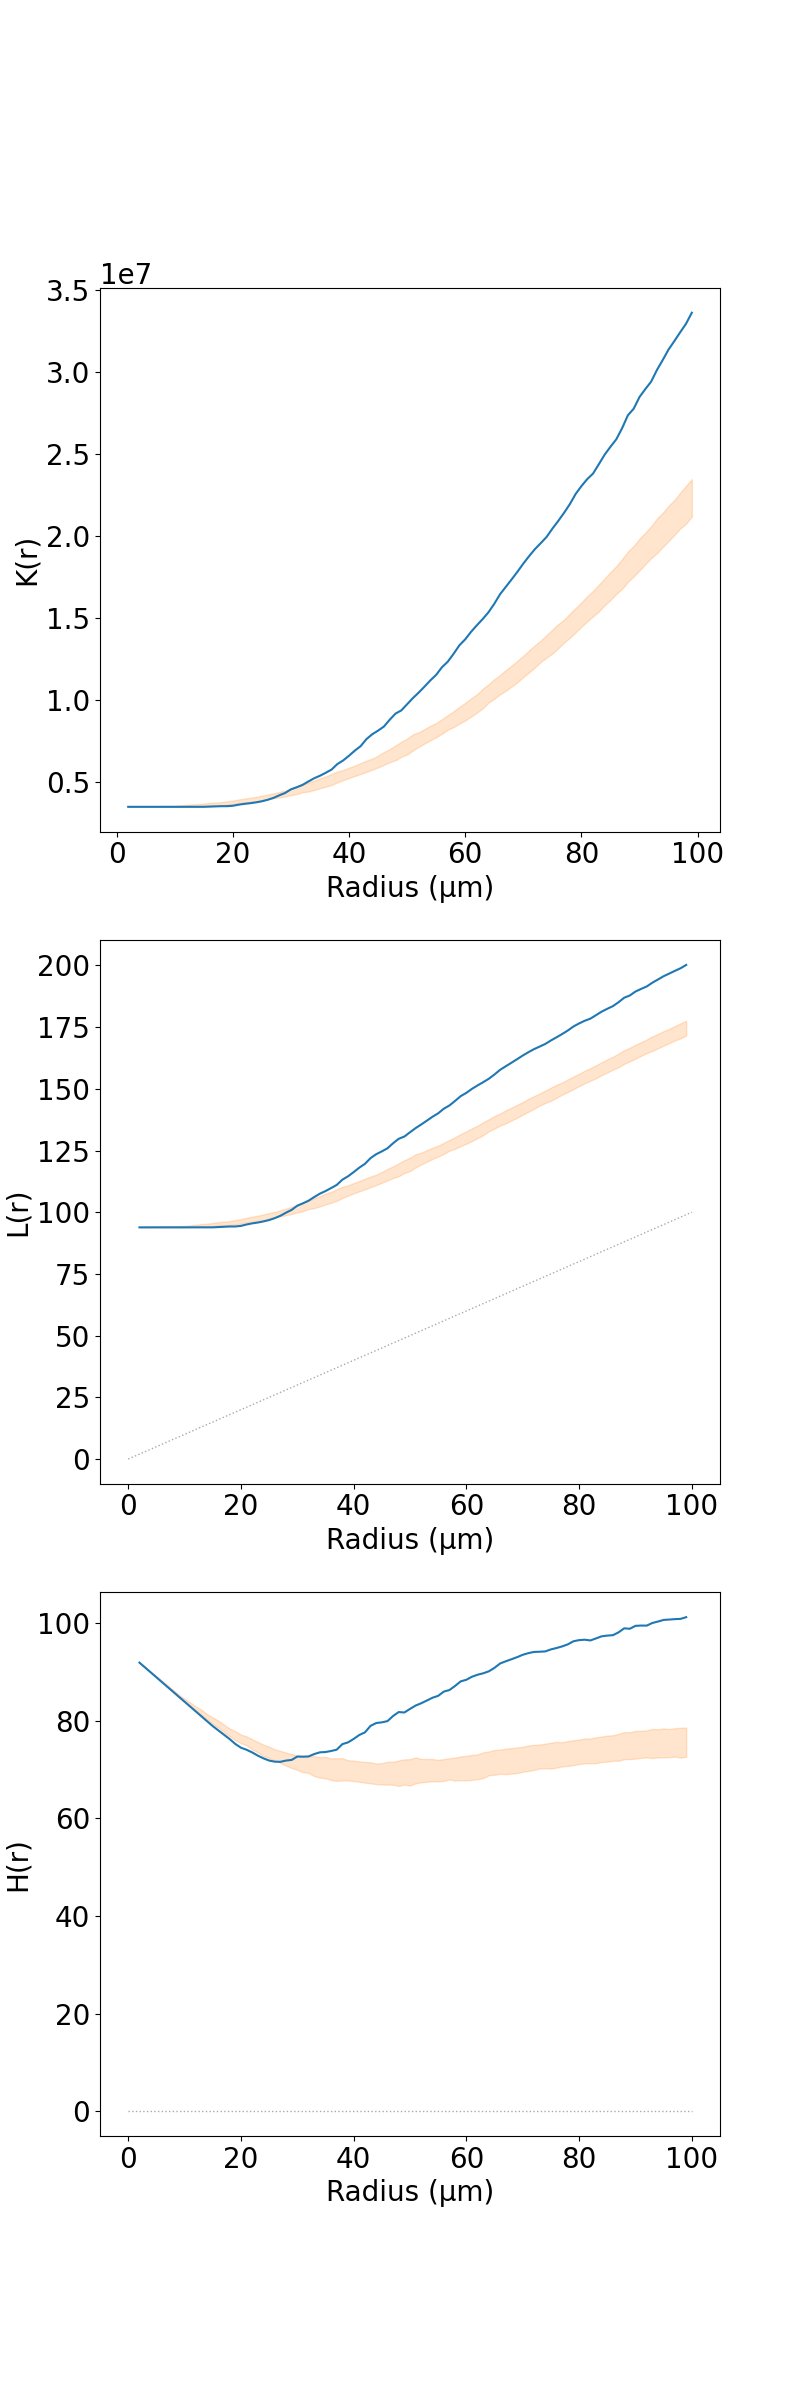

In [8]:
# List of filenames for the CSV files to be processed
filenames = [
    #"FV10__20181106_121902_rstats_w",
    #"FV10__20181009_103052_rstats_w",
    #"FV10__20181004_122358_rstats_w",
    #"FV10__20181008_104428_rstats_w",
    "FV10__20190620_111343_univariate_ng2_rstats",
    #"FV10__20181005_104242_rstats_w",
    #"FV10__20181106_172421_rstats_w",
]

# Loop over each filename
for i, f in enumerate(filenames):
    # Construct the path for the CSV file
    rstats_path = f"/home/dkermany/ripley_results/{f}.csv"
    
    # Construct the path for the random CSV file
    rand_rstats_path = f"/home/dkermany/ripley_results/FV10__{'_'.join(f.split('_')[2:4])}_random_univariate_ng2_rstats.csv"
    
    # Print the progress of the processing
    print(f"{i}/{len(filenames)}: {f}")

    # Load the CSV file and random CSV file into DataFrames
    rstats = load_csv(rstats_path)
    rand_rstats = load_csv(rand_rstats_path)
    
    ## Uncomment to restrict maximum radius in the plots
    # Filter the DataFrames to only include rows where the radius is less than or equal to 102
    rstats = rstats[rstats["Radius (r)"] <= 102]
    rand_rstats = rand_rstats[rand_rstats["Radius (r)"] <= 102]
    print(rstats_path)
    
    # Set the tick label format to plain
    plt.ticklabel_format(style="plain")
    
    # Update the font size for the plot
    plt.rcParams.update({"font.size": 20})
    
    # Create a subplot with 3 rows and 1 column
    f, axes = plt.subplots(3, figsize=(8,24))

    # Plot the K(r) values for the data and the random data
    sns.lineplot(data=rstats, x="Radius (r)", y="K(r)", ax=axes[0])
    sns.lineplot(data=rand_rstats, x="Radius (r)", y="K(r)", ax=axes[0], alpha=0, errorbar=("pi", 95))
    axes[0].set(xlabel="Radius (μm)")
    
    # Plot the L(r) values for the data and the random data
    sns.lineplot(data=rstats, x="Radius (r)", y="L(r)", ax=axes[1])
    sns.lineplot(data=rand_rstats, x="Radius (r)", y="L(r)", ax=axes[1], alpha=0, errorbar=("pi", 95))
    
    # Add a line representing the expected L(r) values
    axes[1].plot([0, 100], [0, 100], linewidth=1, linestyle="dotted", color="#aaa") 
    axes[1].set(xlabel="Radius (μm)")
    
    # Plot the H(r) values for the data and the random data
    sns.lineplot(data=rstats, x="Radius (r)", y="H(r)", ax=axes[2])
    sns.lineplot(data=rand_rstats, x="Radius (r)", y="H(r)", ax=axes[2], alpha=0, errorbar=("pi", 95))
    
    # Add a line representing the expected H(r) values
    axes[2].plot([0, 100], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") 
    axes[2].set(xlabel="Radius (μm)")

    # Uncomment the following line to save the plot as a PNG file
    # plt.savefig(f"/home/dkermany/ripley_plots/{f}.png", dpi=600)
    
    # Display the plot
    plt.show()

In [9]:
rstats

,Unnamed: 0,Radius (r),K(r),L(r),H(r)
0,0,2,3.465217e+06,93.874426,91.874426
1,1,3,3.465217e+06,93.874426,90.874426
2,2,4,3.465217e+06,93.874426,89.874426
3,3,5,3.465217e+06,93.874426,88.874426
4,4,6,3.465217e+06,93.874426,87.874426
...,...,...,...,...,...
93,93,95,3.135568e+07,195.618166,100.618166
94,94,96,3.187481e+07,196.691833,100.691833
95,95,97,3.240692e+07,197.780310,100.780310
96,96,98,3.292605e+07,198.830816,100.830816


In [10]:
rand_rstats

,Unnamed: 0,Radius (r),K(r),L(r),H(r),Line
0,0,2,3.465217e+06,93.874426,91.874426,NaN
1,1,3,3.465217e+06,93.874426,90.874426,NaN
2,2,4,3.465217e+06,93.874426,89.874426,NaN
3,3,5,3.478196e+06,93.991476,88.991476,NaN
4,4,6,3.478196e+06,93.991476,87.991476,NaN
...,...,...,...,...,...,...
9795,9795,95,2.022026e+07,169.004924,74.004924,99.0
9796,9796,96,2.062259e+07,170.118485,74.118485,99.0
9797,9797,97,2.099896e+07,171.147166,74.147166,99.0
9798,9798,98,2.149214e+07,172.476654,74.476654,99.0
